# NVDA Stock Forecasting: ML → Monte Carlo Pipeline

Minimal ML baseline + Monte Carlo simulation with HPC-ready placeholder (Numba).


In [1]:
# Setup: Imports and environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import time
import os

# Try to import numba
try:
    from numba import njit, prange
    NUMBA_AVAILABLE = True
    print("✓ Numba available - HPC backend enabled")
except ImportError:
    NUMBA_AVAILABLE = False
    print("⚠ Numba not available - using serial backend")

# Paths
CSV_PATH = "../examples/NVDA_data_2010_2025.csv"
os.makedirs("../outputs", exist_ok=True)


✓ Numba available - HPC backend enabled


## 1. Load & Preprocess Data


In [2]:
# Load CSV and preprocess
df = pd.read_csv(CSV_PATH, parse_dates=["date"])
df = df[df["ticker"] == "NVDA"].copy()

# Compute 30-day rolling features
df["mu_rolling"] = df["log_returns"].rolling(30).mean()
df["sigma_rolling"] = df["log_returns"].rolling(30).std()

# Drop NaN
df = df.dropna(subset=["mu_rolling", "sigma_rolling"])

# Keep minimal columns
df = df[["date", "ticker", "close", "log_returns", "mu_rolling", "sigma_rolling"]]

print(f"Data shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
df.info()
df.head(3)


Data shape: (3953, 6)
Date range: 2010-02-17 00:00:00-05:00 to 2025-10-31 00:00:00-04:00
<class 'pandas.core.frame.DataFrame'>
Index: 3953 entries, 30 to 3982
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           3953 non-null   object 
 1   ticker         3953 non-null   object 
 2   close          3953 non-null   float64
 3   log_returns    3953 non-null   float64
 4   mu_rolling     3953 non-null   float64
 5   sigma_rolling  3953 non-null   float64
dtypes: float64(4), object(2)
memory usage: 216.2+ KB


,date,ticker,close,log_returns,mu_rolling,sigma_rolling
30,2010-02-17 00:00:00-05:00,NVDA,0.408931,0.009575,-0.001193,0.028211
31,2010-02-18 00:00:00-05:00,NVDA,0.382112,-0.067832,-0.003937,0.030540
32,2010-02-19 00:00:00-05:00,NVDA,0.380049,-0.005414,-0.004330,0.030479


In [3]:
## 2. ML Baseline: Predict Next-Day Returns


ML R² Score: -0.0225


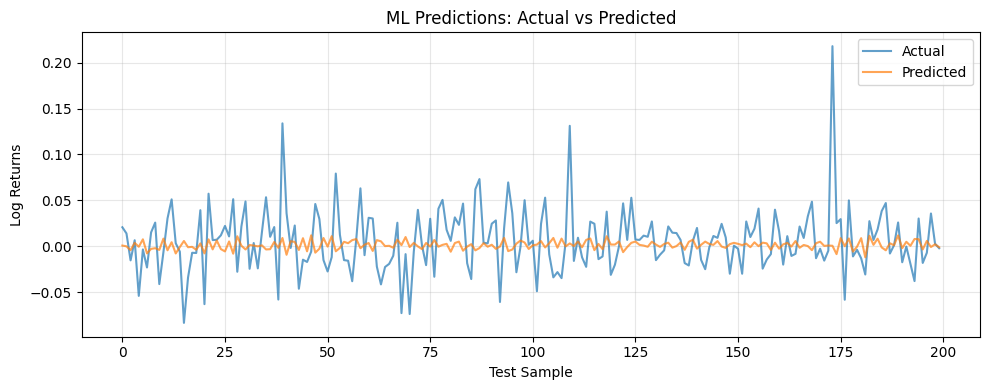

✓ Saved: outputs/nvda_ml_pred.csv


,date,y_true,y_pred
0,2022-09-16 00:00:00-04:00,0.020592,0.000660
1,2022-09-19 00:00:00-04:00,0.013845,-0.000185
2,2022-09-20 00:00:00-04:00,-0.015514,-0.004352
3,2022-09-21 00:00:00-04:00,0.006431,0.003651
4,2022-09-22 00:00:00-04:00,-0.054231,-0.000687


In [4]:
# Build windowed features: predict next-day log_returns from 30-day window
WINDOW = 30
log_rets = df["log_returns"].values
N = len(log_rets)

X, y = [], []
for i in range(N - WINDOW):
    X.append(log_rets[i:i+WINDOW])
    y.append(log_rets[i+WINDOW])

X = np.array(X)
y = np.array(y)

# Train/test split (80/20)
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Fit linear regression
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"ML R² Score: {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test[:200], label="Actual", alpha=0.7)
plt.plot(y_pred[:200], label="Predicted", alpha=0.7)
plt.xlabel("Test Sample")
plt.ylabel("Log Returns")
plt.title("ML Predictions: Actual vs Predicted")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Save ML predictions
dates_test = df["date"].values[WINDOW + split_idx:]
ml_pred_df = pd.DataFrame({
    "date": dates_test,
    "y_true": y_test,
    "y_pred": y_pred
})
ml_pred_df.to_csv("../outputs/nvda_ml_pred.csv", index=False)
print(f"✓ Saved: outputs/nvda_ml_pred.csv")
ml_pred_df.head()


## 3. Monte Carlo Simulation (Serial & Numba Backends)


In [5]:
# Monte Carlo parameters
STEPS = 252
N_PATHS = 5000
S0 = df["close"].iloc[-1]
MU = df["mu_rolling"].iloc[-1]
SIGMA = df["sigma_rolling"].iloc[-1]
DT = 1 / 252

print(f"MC Parameters:")
print(f"  S0 = ${S0:.2f}")
print(f"  μ (annualized) = {MU * 252:.4f}")
print(f"  σ (annualized) = {SIGMA * np.sqrt(252):.4f}")
print(f"  Steps = {STEPS}")
print(f"  Paths = {N_PATHS}")

# Serial backend
def simulate_paths_serial(mu, sigma, s0, steps=252, n_paths=5000, dt=1/252):
    """Plain NumPy loop implementation."""
    np.random.seed(42)
    paths = np.zeros((n_paths, steps))
    for i in range(n_paths):
        s = s0
        for j in range(steps):
            z = np.random.normal()
            s *= np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)
            paths[i, j] = s
    return paths

# Numba HPC backend (if available)
if NUMBA_AVAILABLE:
    @njit(parallel=True, fastmath=True)
    def simulate_paths_numba(mu, sigma, s0, steps=252, n_paths=5000, dt=1/252):
        """Numba-parallelized implementation."""
        out = np.empty((n_paths, steps))
        for i in prange(n_paths):
            s = s0
            for j in range(steps):
                z = np.random.normal()
                s *= np.exp((mu - 0.5*sigma*sigma)*dt + sigma*np.sqrt(dt)*z)
                out[i, j] = s
        return out

# Runtime helper
def run_mc(mu, sigma, s0, steps=252, n_paths=5000, use_numba=False):
    """Run MC simulation and return paths, backend name, and runtime."""
    t0 = time.time()
    if use_numba and NUMBA_AVAILABLE:
        paths = simulate_paths_numba(mu, sigma, s0, steps, n_paths, dt=1/252)
        backend = "numba"
    else:
        paths = simulate_paths_serial(mu, sigma, s0, steps, n_paths, dt=1/252)
        backend = "serial"
    secs = time.time() - t0
    return paths, backend, secs

# Run both backends
print("\nRunning simulations...")
paths_serial, b1, t1 = run_mc(MU, SIGMA, S0, STEPS, N_PATHS, use_numba=False)
paths_fast, b2, t2 = run_mc(MU, SIGMA, S0, STEPS, N_PATHS, use_numba=True)

print(f"\nTimings:")
print(f"  Serial: {t1:.3f}s ({b1})")
print(f"  {'Numba' if NUMBA_AVAILABLE else 'Fallback'}: {t2:.3f}s ({b2})")
if NUMBA_AVAILABLE:
    print(f"  Speedup: {t1/t2:.2f}x")


MC Parameters:
  S0 = $202.49
  μ (annualized) = 1.1458
  σ (annualized) = 0.3552
  Steps = 252
  Paths = 5000

Running simulations...



Timings:
  Serial: 2.281s (serial)
  Numba: 0.806s (numba)
  Speedup: 2.83x


## 4. Visualizations & Outputs


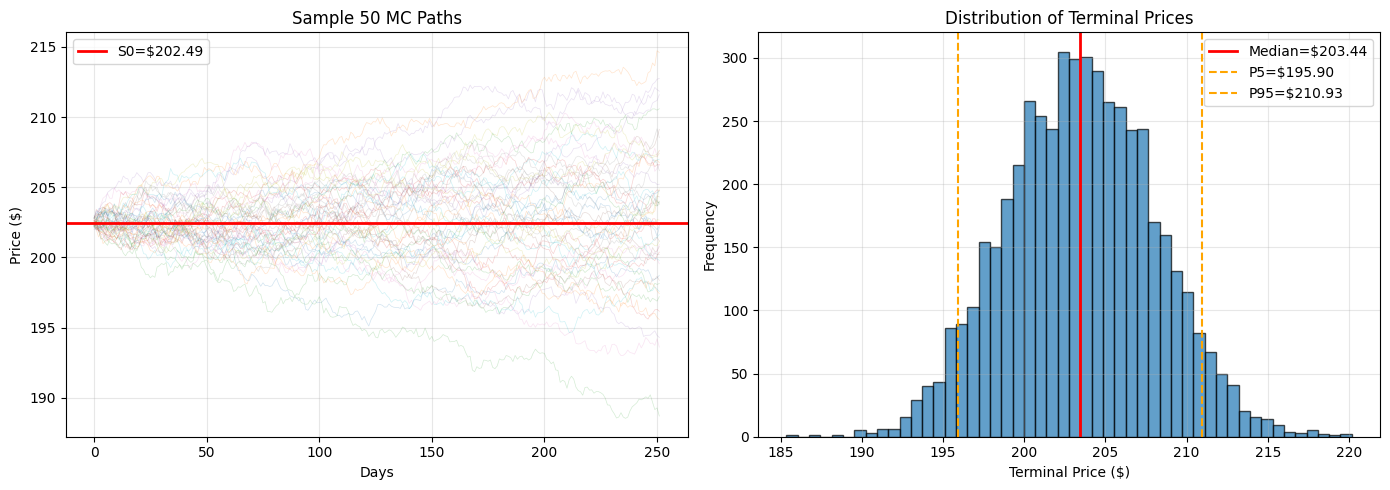

Terminal Price Quantiles:
  P5  = $195.90
  P50 = $203.44
  P95 = $210.93
✓ Saved: outputs/nvda_mc_terminals.csv
✓ Saved: outputs/nvda_mc_meta.json


In [6]:
# Use fastest backend
paths = paths_fast if NUMBA_AVAILABLE else paths_serial

# Plot: sample paths
n_sample = min(50, N_PATHS)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sample paths
sample_indices = np.random.choice(N_PATHS, n_sample, replace=False)
for idx in sample_indices:
    ax1.plot(paths[idx, :], alpha=0.2, linewidth=0.5)
ax1.axhline(S0, color='red', linewidth=2, label=f'S0=${S0:.2f}')
ax1.set_xlabel('Days')
ax1.set_ylabel('Price ($)')
ax1.set_title(f'Sample {n_sample} MC Paths')
ax1.legend()
ax1.grid(alpha=0.3)

# Terminal distribution
terminals = paths[:, -1]
p5, p50, p95 = np.percentile(terminals, [5, 50, 95])
ax2.hist(terminals, bins=50, alpha=0.7, edgecolor='black')
ax2.axvline(p50, color='red', linewidth=2, label=f'Median=${p50:.2f}')
ax2.axvline(p5, color='orange', linestyle='--', label=f'P5=${p5:.2f}')
ax2.axvline(p95, color='orange', linestyle='--', label=f'P95=${p95:.2f}')
ax2.set_xlabel('Terminal Price ($)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Terminal Prices')
ax2.legend()
ax2.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Terminal Price Quantiles:")
print(f"  P5  = ${p5:.2f}")
print(f"  P50 = ${p50:.2f}")
print(f"  P95 = ${p95:.2f}")

# Save outputs
pd.DataFrame({"terminal_price": terminals}).to_csv("../outputs/nvda_mc_terminals.csv", index=False)
print(f"✓ Saved: outputs/nvda_mc_terminals.csv")

import json
meta = {
    "S0": float(S0),
    "MU": float(MU * 252),  # annualized
    "SIGMA": float(SIGMA * np.sqrt(252)),  # annualized
    "STEPS": STEPS,
    "N_PATHS": N_PATHS,
    "backend": b2,
    "runtime_seconds": float(t2)
}
with open("../outputs/nvda_mc_meta.json", "w") as f:
    json.dump(meta, f, indent=2)
print(f"✓ Saved: outputs/nvda_mc_meta.json")


## 5. Sanity Checks


In [7]:
# Print last 5 rows of preprocessed data
print("Last 5 rows of preprocessed data:")
print(df[["date", "close", "mu_rolling", "sigma_rolling"]].tail())

# Print ML R² and predictions
print(f"\nML R² Score: {r2:.4f}")
print(f"\nFirst 5 ML predictions:")
print(ml_pred_df.head())

# Print MC meta and quantiles
print(f"\nMC Metadata:")
print(json.dumps(meta, indent=2))
print(f"\nMC Terminal Price Quantiles:")
print(f"  P5  = ${p5:.2f}")
print(f"  P50 = ${p50:.2f}")
print(f"  P95 = ${p95:.2f}")


Last 5 rows of preprocessed data:
                           date       close  mu_rolling  sigma_rolling
3978  2025-10-27 00:00:00-04:00  191.490005    0.002482       0.021551
3979  2025-10-28 00:00:00-04:00  201.029999    0.004645       0.022823
3980  2025-10-29 00:00:00-04:00  207.039993    0.006514       0.022469
3981  2025-10-30 00:00:00-04:00  202.889999    0.004694       0.022347
3982  2025-10-31 00:00:00-04:00  202.490005    0.004547       0.022377

ML R² Score: -0.0225

First 5 ML predictions:
                        date    y_true    y_pred
0  2022-09-16 00:00:00-04:00  0.020592  0.000660
1  2022-09-19 00:00:00-04:00  0.013845 -0.000185
2  2022-09-20 00:00:00-04:00 -0.015514 -0.004352
3  2022-09-21 00:00:00-04:00  0.006431  0.003651
4  2022-09-22 00:00:00-04:00 -0.054231 -0.000687

MC Metadata:
{
  "S0": 202.4900054931641,
  "MU": 1.145818417623006,
  "SIGMA": 0.35522451479676215,
  "STEPS": 252,
  "N_PATHS": 5000,
  "backend": "numba",
  "runtime_seconds": 0.8063170909881592
